In [1]:
import sys
# FIRE studio libraries
sys.path.append('/mnt/home/jstern/gizmo_analysis/pysrc/')
sys.path.append('/mnt/home/jstern/gizmo_analysis/FIRE_studio/')

In [2]:
# general python libraries
import time, importlib, sys
from tqdm import tqdm_notebook as tqdm
import pylab as pl, numpy as np, glob, pdb, scipy, scipy.stats
from numpy import log10 as log
import h5py
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import constants as cons, units as un
import abg_python
import firestudio
from firestudio.studios.gas_studio import GasStudio
#from firestudio.studios.star_studio import StarStudio
%matplotlib inline

palettable colormaps are not installed
don't have phil's colormaps


In [3]:
import first_pass as fp

Behroozi+18 not loaded


In [4]:
directory = '/mnt/home/jstern/ceph/sim_outputs/good/'
MW_simfile = directory+"../snapshot_071.hdf5"
NGC891_simfile = "/mnt/home/jstern/Drummond_data/vc200_Rs0_Mdot2069_Rcirc15_fgas02_res1e3/output/snapshot_049.hdf5"
TCMB = 2.726


In [5]:
class Dummy_sim:
    h = 1.
sim = Dummy_sim()

In [6]:
snapshot_MW = fp.KY_snapshot(MW_simfile,sim,center=np.array([0,0,0]))
snapshot = fp.KY_snapshot(NGC891_simfile,sim,center=np.array([0,0,0]))


In [7]:
datadic = {}
datadic['Coordinates'] = np.array([snapshot.coords()[:,0],snapshot.coords()[:,2],snapshot.coords()[:,1]]).T
datadic['BoxSize']=60000
v_los = snapshot.vs()[:,1] #un.km/un.s
datadic["SmoothingLength"] = snapshot.dic[('PartType%d'%0,'SmoothingLength')]
_SZ_mass = snapshot.masses() * snapshot.ne2nHs()

loaded PartType0, Coordinates
loaded PartType0, Velocities
loaded PartType0, SmoothingLength
loaded PartType0, Masses
loaded PartType0, ElectronAbundance


In [8]:
r_max   = 90
Npixels = 60
z_width = 50
filedir=directory
projection_output_filename=directory

In [9]:
kSZmaps =  [None,None]
for j in range(2):
    if j==0: SZ_mass = _SZ_mass * v_los*(v_los>0)
    if j==1: SZ_mass = _SZ_mass * -v_los*(v_los<0)
    datadic['Masses'] = SZ_mass
    mystudio = GasStudio(
     snapnum = 49,
     snapdict = datadic,
     frame_half_width = r_max,
     frame_depth = z_width,
     quantity_name = 'Masses',
     take_log_of_quantity = False, 
     galaxy_extractor = False,
     pixels=Npixels,
     overwrite = True,
     savefig=False,      
     use_hsml=True,
     snapdir = None, 
     datadir= filedir
     )
    kSZmaps[j], _ = mystudio.projectImage([])

extra kwargs:
 ['galaxy_extractor']
Drawing None:49 to:/mnt/home/jstern/ceph/sim_outputs/good/
extracting cube
-done
Using provided smoothing lengths
------------------------------------------
------------------------------------------
log10 minmax(columnDensityMap) -inf 12.262482
log10 minmax(massWeightedQuantityMap) 0.0 0.0


/mnt/home/jstern/gizmo_analysis/FIRE_studio/firestudio/studios/gas_studio.py:326: RuntimeWarning: divide by zero encountered in log10
  columnDensityMap = np.log10(columnDensityMap)


extra kwargs:
 ['galaxy_extractor']
Drawing None:49 to:/mnt/home/jstern/ceph/sim_outputs/good/
extracting cube
-done
Using provided smoothing lengths
------------------------------------------
------------------------------------------
log10 minmax(columnDensityMap) -inf 12.256805
log10 minmax(massWeightedQuantityMap) 0.0 0.0


In [10]:
kSZmap = (10.**kSZmaps[0] - 10**kSZmaps[1]) * (0.7*un.Msun*un.pc**-2/cons.m_p/1e10).to('cm**-2').value   #fix units
kSZmap *= (un.cm**-2* un.km/un.s * cons.sigma_T / cons.c).to('').value 

In [11]:
np.savez('/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/pyobjs/NGC891_kSZ.npz',kSZ = kSZmap.T*TCMB*1e6, extent = np.array([-r_max, r_max, -r_max, r_max]))

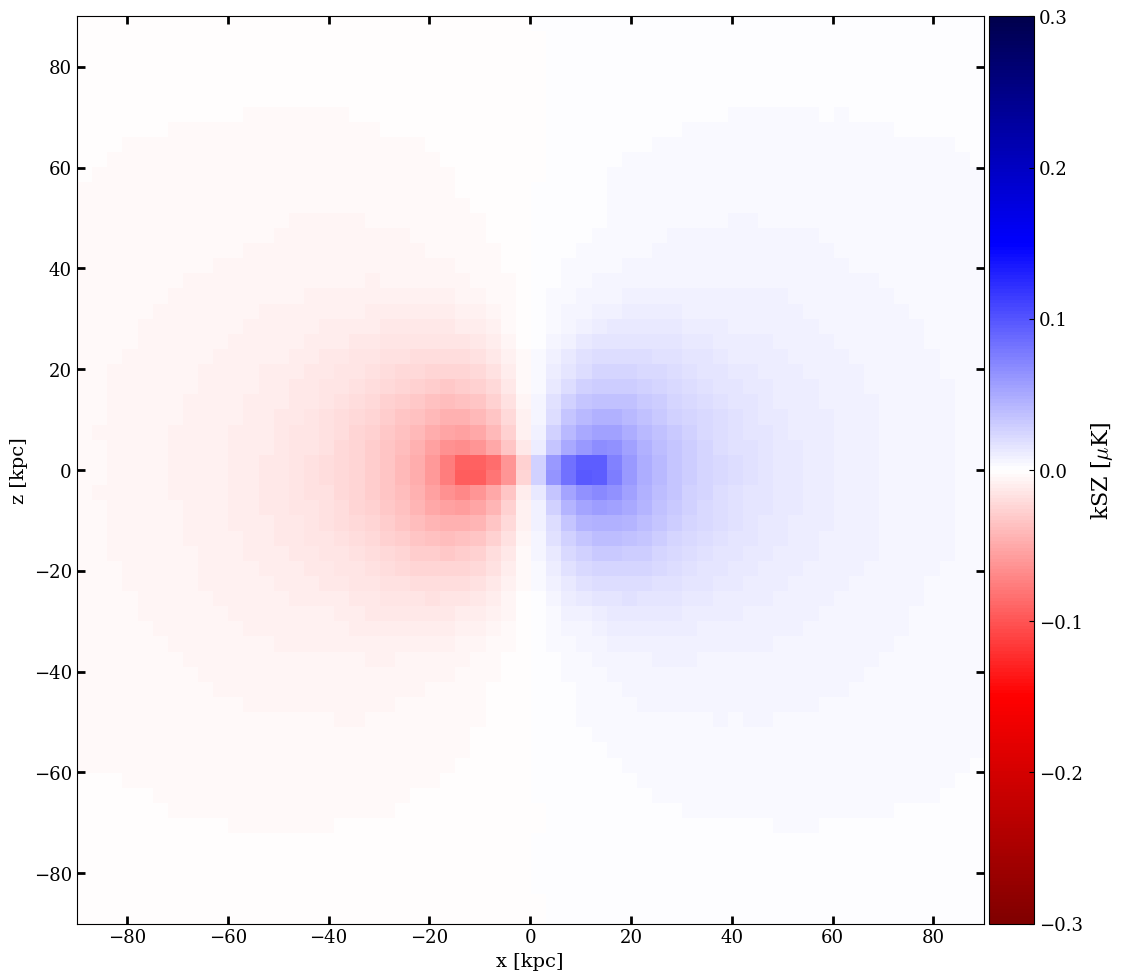

In [12]:
fig, ax = plt.subplots()
fig.subplots_adjust(right=2, top=2)

ksz_Norm = matplotlib.colors.Normalize(vmax=0.3,vmin=-0.3)
im = ax.imshow(kSZmap.T * TCMB * 1e6,cmap='seismic_r',extent=[-r_max, r_max, -r_max, r_max], norm = ksz_Norm)

ax.set_xlabel("x " + "[kpc]", size=14)
ax.set_ylabel("z [kpc]", size=14)
ax.tick_params(length=6, width=2, labelsize=13)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ksz_cb = fig.colorbar(im, cax=cax, orientation='vertical')
ksz_cb.ax.tick_params(labelsize=13)
ksz_cb.set_label(label="kSZ [$\mu$K]", size=16)
ax.tick_params(length=6, width=2, labelsize=13)


In [15]:
snapshot.cos_theta()

array([-0.85030038, -0.84567588, -0.85144953, ...,  0.42860773,
        0.4358995 ,  0.42803147])

In [17]:
rs = snapshot.rs() 
inds = (rs<22) & (rs > 18)
thetas = snapshot.cos_theta()
inds &= (thetas>-0.1) & (thetas<0.1)

In [23]:
(np.median(snapshot.nHs()[inds])*un.cm**-3 * 20*un.kpc * 200*un.km/un.s * cons.sigma_T/cons.c).to('') * 2.7e6

<Quantity 0.05037587>

In [ ]:
#import proj_paths
import edens as e
#import analytical_funcs as a



In [49]:
if True:    
    # create the data dictionary
    datadic = e.load_data(directory, partType=["gas"], keys=["Coordinates","Velocities","Masses","Density","ElectronAbundance","SmoothingLength"])

    # rotate coordinates such that the los is on the z axis
    datadic_r = datadic
    for (los_axis, rot_vec) in list(axes.items())[:2]:
        rotated_r = e.rotate_coords(datadic["gas"]["Coordinates"], rot_vec)
        rotated_v = e.rotate_coords(datadic["gas"]["Velocities"], rot_vec)
        datadic_r["gas"]["Coordinates"] = rotated_r
        datadic_r["gas"]["Velocities"] = rotated_v
    
        # create sz field
        v_los = datadic_r['gas']['Velocities'][:,2] * km/s
        rho = datadic_r['gas']['Density'] * u.Msun10 / kpc**3
        e_a = datadic_r['gas']['ElectronAbundance'] * dimensionless
        n_e = 0.7 * rho * e_a / u.proton_mass
        sz = (v_los * n_e * u.sigma_thompson / u.c)
        datadic_r['gas']['SZ']= sz.value / 1e-3 * 3e18
    
        # create projection 
        mystudio = GasStudio(
         snapnum = 49,
         snapdict = datadic_r['gas'],
         frame_half_width = r_max,
         frame_depth = z_width,
         quantity_name = 'SZ',
         take_log_of_quantity = False, 
         galaxy_extractor = False,
         pixels=1200,
         overwrite = True,
         savefig=False,      
         use_hsml=True,
         snapdir = None, 
         datadir= filedir
         )
        _, map = mystudio.projectImage([])

        if los_axis==1:
            map = map.T
        
        #np.save(os.path.join(proj_paths.PROJDIR,"firestudio_results/data/", simsnapname + "_los_"+axes_names[los_axis]+".npy"), map)
        np.save("/mnt/home/jstern/gizmo_analysis/figures/NGC891_los_"+axes_names[los_axis]+".npy", map)
        plot(map,'NGC891',los_axis)

KeyboardInterrupt: 

In [24]:
snap_path_write = directory
if True:
    # load snapshot to dictionary
    gasdata = e.load_data(snap_path_write, partType=["gas"], keys=["Coordinates","Velocities","ElectronAbundance","InternalEnergy","Metallicity"])
    starsdata = e.load_data(snap_path_write, partType=["stars"], keys=["Coordinates","Velocities"])

    r_gas = gasdata["gas"]["Coordinates"] * kpc
    v_gas = gasdata["gas"]["Velocities"] * km/s
    r_stars = starsdata["stars"]["Coordinates"] * kpc
    v_stars = starsdata["stars"]["Velocities"] * km/s

    # calc temeperature from data
    helium_fraction = gasdata["gas"]["Metallicity"][:,1] * dimensionless
    int_energy = gasdata["gas"]["InternalEnergy"] * (km/s)**2
    e_a = gasdata["gas"]["ElectronAbundance"] * dimensionless
    t_gas = e.temperature(int_energy, e_a, 5/3, helium_fraction)

    # choose only main halo gas (within 50kpc radius around center)
    gas_main_halo_index = r_gas[:,0]**2 + r_gas[:,1]**2 + r_gas[:,2]**2 <50**2
    r_gas_main_halo = r_gas[gas_main_halo_index]
    v_gas_main_halo = r_gas[gas_main_halo_index]
    
    # choose only cold ( < 5e4K ) gas within main halo
    t_gas_main_halo = t_gas[gas_main_halo_index]
    r_cold_gas = r_gas_main_halo[t_gas_main_halo < 5000 * u.K]
    v_cold_gas = v_gas_main_halo[t_gas_main_halo < 5000 * u.K]
    
    # calculate angular momentum of main halo cold gas only (cgm)
    L_cold = e.calc_angular_momentum(r_cold_gas, v_cold_gas)[2]
    
    # align all coordinates
    r_stars_aligned = (e.rotate_coords(r_stars, L_cold))
    v_stars_aligned = (e.rotate_coords(v_stars, L_cold))
    r_gas_aligned = (e.rotate_coords(r_gas, L_cold))
    v_gas_aligned = (e.rotate_coords(v_gas, L_cold))
    
    # write data to file
    e.write_to_fire_sim( snap_path_write+'2', r_gas_aligned, v_gas_aligned, r_stars_aligned, v_stars_aligned)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/home/jstern/ceph/sim_outputs/good/2'